In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..', '..'))
sys.path.append(module_path)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

## Get physical constants from Scipy
import scipy.constants as con
## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m
kb = con.physical_constants['Boltzmann constant in eV/K'][0]

import scipy.integrate as int

import scipy.io as sio

import scipy.optimize as opt

from misloc_mispol_package.parameterize import displaced_osc_model as dom


In [23]:
## This needs to be in a seperate cell from the imports
## Matplotlib settings
## inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 150,  # to adjust notebook inline plot size
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
#     'figure.figsize': [3.5, 2.625], # 4 x 3
#     'figure.figsize': [4, 3], # 4 x 3
    'figure.figsize': [4*1.125, 3*1.125], # 4x3, full slide in keynote
    'font.family': 'serif',
    'figure.max_open_warning':100
}
mpl.rcParams.update(params)


In [24]:
path_to_mol_data = (
    "/Users/chair/Documents/Academia/SuperRes/Biteen_colab/"+
    "Mispolarization/python/gitted/spectral_fitting/")

def norm_spec(spec):
    return spec/spec.max()

def nm_to_ev_correct(spec):
    return spec/(1240/thermo_fisher_dye_data.T[0])**5.

In [25]:
emily_data = np.loadtxt(
    os.path.join(path_to_mol_data, 'toluene.csv'), 
#     skiprows=0, 
    delimiter=','
    )

In [26]:
emily_data

array([[2.74576, 0.00764],
       [2.74418, 0.00767],
       [2.74261, 0.00754],
       ...,
       [1.98401, 0.2051 ],
       [1.98319, 0.20552],
       [1.98237, 0.20594]])

In [27]:
dom.invcmtohz(823)*hbar

0.10203899444999716

Text(0.5, 0, 'Photon Energy $\\hbar\\omega$ [eV]')

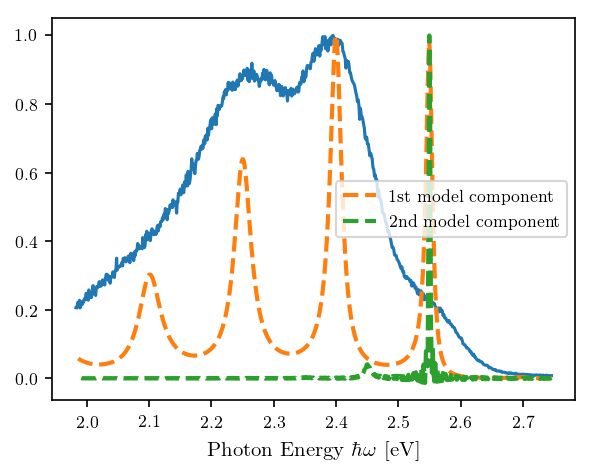

In [33]:
emily_model = dom.mol_fluo_model(
    num_vib_modes=2,
    hbar_omega_eg_0=2.55,
    script_d=[1.9, .6],
    hbar_omega_0=[0.15, .1],
    hbar_gamma=[.01, .01],
    T=300,)

# model_2_mode = emily_model.emission_lineshape(
#     emily_data.T[0]/hbar,
# #     mode_idx,
#     t_bound = 1000,
#     t_points = 10000)

model_1st_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 10000)

model_2nd_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 10000)

plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]))

# plt.plot(emily_data.T[0], norm_spec(model_2_mode), ls=(0, (1, 1)), lw=3, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(model_1st_mode), ls='--', lw=2, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(model_2nd_mode), ls='--', lw=2, label='2nd model component')


plt.legend()
# plt.xlim([1.75, 3])
plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)

# 04/23 
Going to try fitting, but first figure out if I can get the integration faster

In [32]:
def model_from_params(params, num_modes):
    return dom.mol_fluo_model(
        num_vib_modes=num_modes,
        hbar_omega_eg_0=float(params[0]),
        script_d=params[2+2*num_modes: 2+3*num_modes],
        hbar_omega_0=params[2: 2+1*num_modes],
        hbar_gamma=params[2+1*num_modes: 2+2*num_modes],
        T=params[1],)

def muk_mol_fit_fun(params, *args):
    """ Try naive fit function with fixed integration differential size
        and bound.

        Params: (list of fit parameters) Should be list of 
            2 + (3*num_modes) containing the following model parameters;
            ~~~~~~~~~~~~~~~~
            [0] hbar_omega_eg_0: the difference in zero point energy of 
                the vibrational oscillators between the two electronic
                states (eV).
                
            [1] T: temperature 
            
            [2:2+num_modes] hbar_omega_0: vibrational ressonance energy 
                in eV.
                
            [2+num_modes:2+2*num_modes] hbar_gamma: damping rate from 
                solvent or etc.
                
            [2+2*num_modes: 2+3*num_modes]script_d: unitless 
                displacement of the vibronic potential surface between
                electronic states.

        Args: (list of x axis and data)
        ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            hbar_omega:
            data:
            num_modes:
        """
#     print(f'params:{params}, args:{args}')
    ## Define params and args with meaningful names
#     hbar_omega_eg_0, T, hbar_omega_0, hbar_gamma, script_d, = params
    ## params are ordered by 
    hbar_omegas, data, num_modes, t_bound, t_points, norm = args

    model_instance = model_from_params(params, num_modes)
    
    model = model_instance.emission_lineshape(
        hbar_omegas/hbar,
        t_bound=t_bound,
        t_points=t_points,)

    ## Normalize model and data
    model = model / np.max(model)
    data = data / np.max(data)

    return model - data

In [93]:
# hbar_omega_eg_0=2.55,
#     script_d=[1.9, .6],
#     hbar_omega_0=[0.15, .1],
#     hbar_gamma=[.01, .01],
#     T=300

ini_hbar_omega_eg_0 = 2.55
ini_script_d = [1.9, .6]
ini_hbar_omega_0 = [0.15, .1]
ini_hbar_gamma = [.01, .01]
ini_T = 300

bounds_hbar_omega_eg_0 = [2.549, 2.551]
bounds_script_d = [[0, 0], [np.inf, np.inf]]
bounds_hbar_omega_0 = [[0, 0], [np.inf, np.inf]]
bounds_hbar_gamma = [[0.001, 0], [np.inf, np.inf]]
bounds_T = [299, 301]


fit_ini_guess = np.asarray([
    ini_hbar_omega_eg_0,
    ini_T,
    *ini_hbar_omega_0,
    *ini_hbar_gamma,
    *ini_script_d,
    ])


hbar_omegas_arg = emily_data.T[0]
data_arg = emily_data.T[1]
num_modes_arg = 2
t_bound_arg = 1000
t_points_arg = 1000
norm_arg = True

fit_args = (
    hbar_omegas_arg,
    data_arg,
    num_modes_arg,
    t_bound_arg,
    t_points_arg,
    norm_arg,
    )

## Build bounds arrays
bounds = np.zeros((2, fit_ini_guess.shape[0]))
bounds[:, 0] = bounds_hbar_omega_eg_0
bounds[:, 1] = bounds_T
bounds[:, 2:2+num_modes_arg] = bounds_hbar_omega_0
bounds[:, 2+num_modes_arg:2+2*num_modes_arg] = bounds_hbar_gamma
bounds[:, 2+2*num_modes_arg:2+3*num_modes_arg] = bounds_script_d

model_fit = opt.least_squares(
    muk_mol_fit_fun,
    x0=fit_ini_guess,
    args=fit_args,
    bounds=bounds
    )

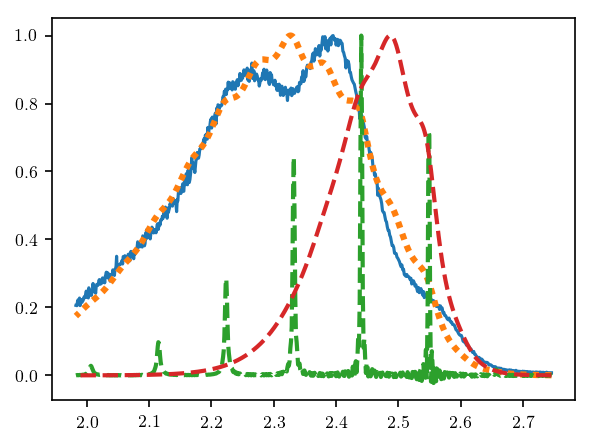

In [94]:
model_fit_inst = model_from_params(model_fit['x'], 2)

model_2_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 1000)

model_1st_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 1000)

model_2nd_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 1000)

plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]))

plt.plot(emily_data.T[0], norm_spec(model_2_mode), ls=(0, (1, 1)), lw=3, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(model_1st_mode), ls='--', lw=2, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(model_2nd_mode), ls='--', lw=2, label='2nd model component')

In [220]:
# hbar_omega_eg_0=2.55,
#     script_d=[1.9, .6],
#     hbar_omega_0=[0.15, .1],
#     hbar_gamma=[.01, .01],
#     T=300

ini_hbar_omega_eg_0 = 2.55
ini_script_d = [1.9, .6]
ini_hbar_omega_0 = [0.15, .1]
ini_hbar_gamma = [.01, .01]
ini_T = 300

bounds_hbar_omega_eg_0 = [2.549, 2.6]
bounds_script_d = [[0, 0], [np.inf, np.inf]]
bounds_hbar_omega_0 = [[0, 0], [np.inf, np.inf]]
bounds_hbar_gamma = [[0.005, 0], [np.inf, np.inf]]
bounds_T = [299, 301]


fit_ini_guess = np.asarray([
    ini_hbar_omega_eg_0,
    ini_T,
    *ini_hbar_omega_0,
    *ini_hbar_gamma,
    *ini_script_d,
    ])


hbar_omegas_arg = emily_data.T[0]
data_arg = emily_data.T[1]
num_modes_arg = 2
t_bound_arg = 1000
t_points_arg = 1000
norm_arg = True

fit_args = (
    hbar_omegas_arg,
    data_arg,
    num_modes_arg,
    t_bound_arg,
    t_points_arg,
    norm_arg,
    )

## Build bounds arrays
bounds = np.zeros((2, fit_ini_guess.shape[0]))
bounds[:, 0] = bounds_hbar_omega_eg_0
bounds[:, 1] = bounds_T
bounds[:, 2:2+num_modes_arg] = bounds_hbar_omega_0
bounds[:, 2+num_modes_arg:2+2*num_modes_arg] = bounds_hbar_gamma
bounds[:, 2+2*num_modes_arg:2+3*num_modes_arg] = bounds_script_d

model_fit = opt.least_squares(
    muk_mol_fit_fun,
    x0=fit_ini_guess,
    args=fit_args,
    bounds=bounds
    )

Text(0, 0.5, 'Normalized Emission Probability')

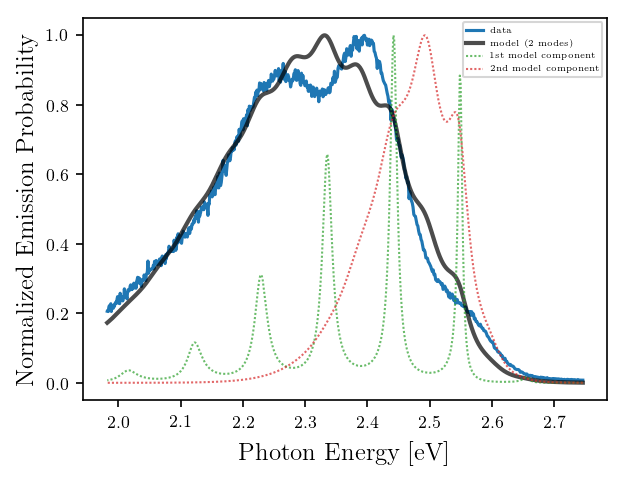

In [222]:
model_fit_inst = model_from_params(model_fit['x'], 2)

model_2_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 1000)

model_1st_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 1000)

model_2nd_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 1000)

plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]), label='data')

plt.plot(emily_data.T[0], norm_spec(model_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(model_1st_mode), ls=(0, (1, 1)), lw=1, c='C2', alpha=0.7, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(model_2nd_mode), ls=(0, (1, 1)), lw=1, c='C3', alpha=0.7, label='2nd model component')
# plt.plot(emily_data.T[0], norm_spec(model_3rd_mode), ls=(0, (1, 1)), lw=1, c='C4', alpha=0.7, label='2nd model component')

plt.legend(fontsize=4)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Normalized Emission Probability')

In [223]:
model_fit['x']

array([2.54900000e+00, 2.99000000e+02, 1.06771030e-01, 5.50949451e-02,
       5.00000000e-03, 1.50120611e-02, 1.87242851e+00, 1.71245859e+00])

In [226]:
# hbar_omega_eg_0=2.55,
#     script_d=[1.9, .6],
#     hbar_omega_0=[0.15, .1],
#     hbar_gamma=[.01, .01],
#     T=300

ini_hbar_omega_eg_0 = 2.55
ini_script_d = [1.9, .6]
ini_hbar_omega_0 = [0.15, .1]
ini_hbar_gamma = [.01, .01]
ini_T = 300

bounds_hbar_omega_eg_0 = [2.45, 2.65]
bounds_script_d = [[0, 0], [np.inf, np.inf]]
bounds_hbar_omega_0 = [[0, 0], [np.inf, np.inf]]
bounds_hbar_gamma = [[0.005, 0], [np.inf, np.inf]]
bounds_T = [299, 301]


fit_ini_guess = np.asarray([
    ini_hbar_omega_eg_0,
    ini_T,
    *ini_hbar_omega_0,
    *ini_hbar_gamma,
    *ini_script_d,
    ])


hbar_omegas_arg = emily_data.T[0]
data_arg = emily_data.T[1]
num_modes_arg = 2
t_bound_arg = 1000
t_points_arg = 1000
norm_arg = True

fit_args = (
    hbar_omegas_arg,
    data_arg,
    num_modes_arg,
    t_bound_arg,
    t_points_arg,
    norm_arg,
    )

## Build bounds arrays
bounds = np.zeros((2, fit_ini_guess.shape[0]))
bounds[:, 0] = bounds_hbar_omega_eg_0
bounds[:, 1] = bounds_T
bounds[:, 2:2+num_modes_arg] = bounds_hbar_omega_0
bounds[:, 2+num_modes_arg:2+2*num_modes_arg] = bounds_hbar_gamma
bounds[:, 2+2*num_modes_arg:2+3*num_modes_arg] = bounds_script_d

model_fit = opt.least_squares(
    muk_mol_fit_fun,
    x0=fit_ini_guess,
    args=fit_args,
    bounds=bounds
    )

array([2.54059083e+00, 3.01000000e+02, 1.08843877e-01, 5.66406126e-02,
       5.00000000e-03, 1.85735385e-02, 1.85072224e+00, 1.62409547e+00])

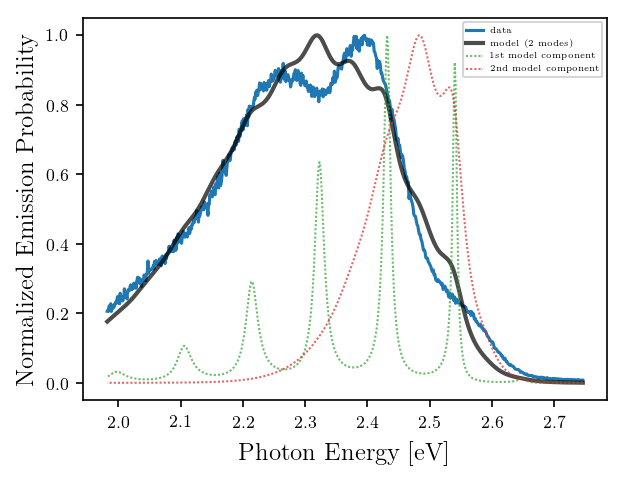

In [228]:
model_fit_inst = model_from_params(model_fit['x'], 2)

model_2_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 1000)

model_1st_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 1000)

model_2nd_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 1000)

plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]), label='data')

plt.plot(emily_data.T[0], norm_spec(model_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(model_1st_mode), ls=(0, (1, 1)), lw=1, c='C2', alpha=0.7, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(model_2nd_mode), ls=(0, (1, 1)), lw=1, c='C3', alpha=0.7, label='2nd model component')
# plt.plot(emily_data.T[0], norm_spec(model_3rd_mode), ls=(0, (1, 1)), lw=1, c='C4', alpha=0.7, label='2nd model component')

plt.legend(fontsize=4)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Normalized Emission Probability')

model_fit['x']

    fit_hbar_omega_eg_0=2.54059083e+00,
    fit_T=3.01000000e+02,
    *fit_hbar_omega_0=1.08843877e-01, 5.66406126e-02,
    *fit_hbar_gamma=5.00000000e-03, 1.85735385e-02,
    *fit_script_d=1.85072224e+00, 1.62409547e+00,

In [229]:
# hbar_omega_eg_0=2.55,
#     script_d=[1.9, .6],
#     hbar_omega_0=[0.15, .1],
#     hbar_gamma=[.01, .01],
#     T=300

ini_hbar_omega_eg_0 = 2.5
ini_script_d = [1.9, .6]
ini_hbar_omega_0 = [0.1, .1]
ini_hbar_gamma = [.01, .01]
ini_T = 300

bounds_hbar_omega_eg_0 = [2.45, 2.65]
bounds_script_d = [[0, 0], [np.inf, np.inf]]
bounds_hbar_omega_0 = [[0, 0], [np.inf, np.inf]]
bounds_hbar_gamma = [[0.005, 0], [np.inf, np.inf]]
bounds_T = [299, 301]


fit_ini_guess = np.asarray([
    ini_hbar_omega_eg_0,
    ini_T,
    *ini_hbar_omega_0,
    *ini_hbar_gamma,
    *ini_script_d,
    ])


hbar_omegas_arg = emily_data.T[0]
data_arg = emily_data.T[1]
num_modes_arg = 2
t_bound_arg = 1000
t_points_arg = 1000
norm_arg = True

fit_args = (
    hbar_omegas_arg,
    data_arg,
    num_modes_arg,
    t_bound_arg,
    t_points_arg,
    norm_arg,
    )

## Build bounds arrays
bounds = np.zeros((2, fit_ini_guess.shape[0]))
bounds[:, 0] = bounds_hbar_omega_eg_0
bounds[:, 1] = bounds_T
bounds[:, 2:2+num_modes_arg] = bounds_hbar_omega_0
bounds[:, 2+num_modes_arg:2+2*num_modes_arg] = bounds_hbar_gamma
bounds[:, 2+2*num_modes_arg:2+3*num_modes_arg] = bounds_script_d

model_fit = opt.least_squares(
    muk_mol_fit_fun,
    x0=fit_ini_guess,
    args=fit_args,
    bounds=bounds
    )

array([2.50290201e+00, 3.00967721e+02, 7.59593639e-02, 7.52958398e-01,
       5.00000000e-03, 2.20823190e+00, 1.97849888e+00, 5.63277666e-01])

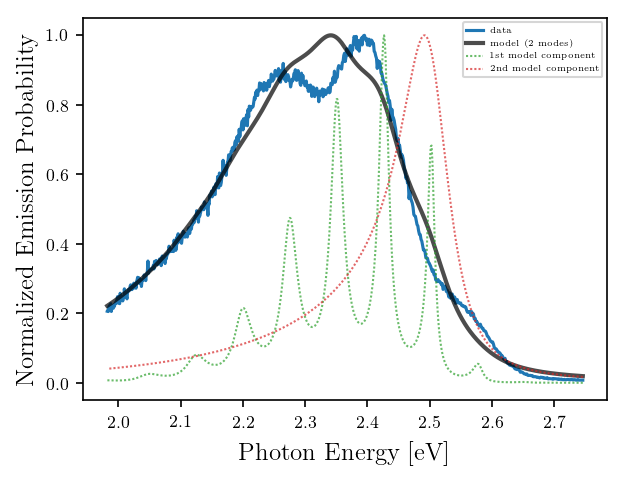

In [230]:
model_fit_inst = model_from_params(model_fit['x'], 2)

model_2_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 1000)

model_1st_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 1000)

model_2nd_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 1000)

plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]), label='data')

plt.plot(emily_data.T[0], norm_spec(model_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(model_1st_mode), ls=(0, (1, 1)), lw=1, c='C2', alpha=0.7, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(model_2nd_mode), ls=(0, (1, 1)), lw=1, c='C3', alpha=0.7, label='2nd model component')
# plt.plot(emily_data.T[0], norm_spec(model_3rd_mode), ls=(0, (1, 1)), lw=1, c='C4', alpha=0.7, label='2nd model component')

plt.legend(fontsize=4)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Normalized Emission Probability')

model_fit['x']


    , , ,
       , 

In [224]:
# hbar_omega_eg_0=2.55,
#     script_d=[1.9, .6],
#     hbar_omega_0=[0.15, .1],
#     hbar_gamma=[.01, .01],
#     T=300

ini_hbar_omega_eg_0 = 2.55
ini_script_d = [1.7, .6]
ini_hbar_omega_0 = [0.15, .1]
ini_hbar_gamma = [.01, .01]
ini_T = 300

bounds_hbar_omega_eg_0 = [2.549, 2.6]
bounds_script_d = [[0, 0], [np.inf, np.inf]]
bounds_hbar_omega_0 = [[0.13, 0.], [np.inf, .1]]
bounds_hbar_gamma = [[0.005, 0.005], [np.inf, np.inf]]
bounds_T = [299, 301]


fit_ini_guess = np.asarray([
    ini_hbar_omega_eg_0,
    ini_T,
    *ini_hbar_omega_0,
    *ini_hbar_gamma,
    *ini_script_d,
    ])


hbar_omegas_arg = emily_data.T[0]
data_arg = emily_data.T[1]
num_modes_arg = 2
t_bound_arg = 1000
t_points_arg = 1000
norm_arg = True

fit_args = (
    hbar_omegas_arg,
    data_arg,
    num_modes_arg,
    t_bound_arg,
    t_points_arg,
    norm_arg,
    )

## Build bounds arrays
bounds = np.zeros((2, fit_ini_guess.shape[0]))
bounds[:, 0] = bounds_hbar_omega_eg_0
bounds[:, 1] = bounds_T
bounds[:, 2:2+num_modes_arg] = bounds_hbar_omega_0
bounds[:, 2+num_modes_arg:2+2*num_modes_arg] = bounds_hbar_gamma
bounds[:, 2+2*num_modes_arg:2+3*num_modes_arg] = bounds_script_d

model_fit = opt.least_squares(
    muk_mol_fit_fun,
    x0=fit_ini_guess,
    args=fit_args,
    bounds=bounds
    )

array([2.54900000e+00, 2.99000000e+02, 1.74701169e-01, 7.73811911e-03,
       5.00000000e-03, 2.10468207e+00, 1.16589397e+00, 6.38590306e+00])

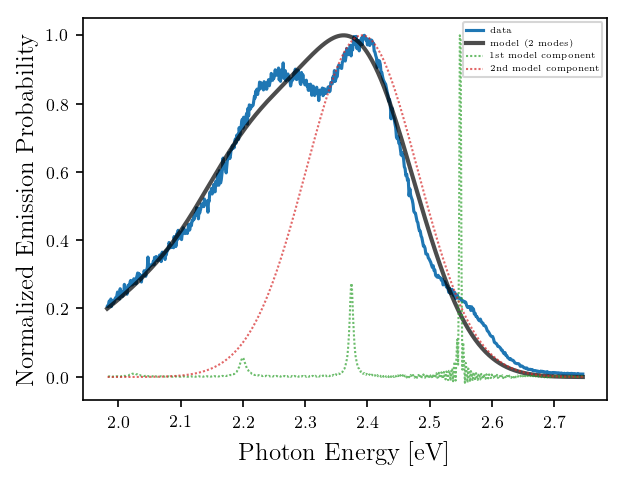

In [225]:
model_fit_inst = model_from_params(model_fit['x'], 2)

model_2_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 1000)

model_1st_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 1000)

model_2nd_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 1000)

plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]), label='data')

plt.plot(emily_data.T[0], norm_spec(model_2_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(model_1st_mode), ls=(0, (1, 1)), lw=1, c='C2', alpha=0.7, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(model_2nd_mode), ls=(0, (1, 1)), lw=1, c='C3', alpha=0.7, label='2nd model component')
# plt.plot(emily_data.T[0], norm_spec(model_3rd_mode), ls=(0, (1, 1)), lw=1, c='C4', alpha=0.7, label='2nd model component')

plt.legend(fontsize=4)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Normalized Emission Probability')

model_fit['x']


fit_hbar_omega_eg_0=2.54900000e+00, 
fit_T=2.99000000e+02, 
*fit_hbar_omega_0=1.74701169e-01, 7.73811911e-03,
*fit_hbar_gamma=5.00000000e-03, 2.10468207e+00, 
*fit_script_d=1.16589397e+00, 6.38590306e+00]

In [68]:
# hbar_omega_eg_0=2.55,
#     script_d=[1.9, .6],
#     hbar_omega_0=[0.15, .1],
#     hbar_gamma=[.01, .01],
#     T=300

ini_hbar_omega_eg_0 = 2.55
ini_script_d = [1.9, .6]
ini_hbar_omega_0 = [0.15, .1]
ini_hbar_gamma = [.01, .01]
ini_T = 300

bounds_hbar_omega_eg_0 = [2.549, 2.551]
bounds_script_d = [[0, 0], [np.inf, np.inf]]
bounds_hbar_omega_0 = [[0, 0], [np.inf, np.inf]]
bounds_hbar_gamma = [[0.0, 0], [np.inf, np.inf]]
bounds_T = [299, 301]


fit_ini_guess = np.asarray([
    ini_hbar_omega_eg_0,
    ini_T,
    *ini_hbar_omega_0,
    *ini_hbar_gamma,
    *ini_script_d,
    ])


hbar_omegas_arg = emily_data.T[0]
data_arg = emily_data.T[1]
num_modes_arg = 2
t_bound_arg = 1000
t_points_arg = 1000
norm_arg = True

fit_args = (
    hbar_omegas_arg,
    data_arg,
    num_modes_arg,
    t_bound_arg,
    t_points_arg,
    norm_arg,
    )

## Build bounds arrays
bounds = np.zeros((2, fit_ini_guess.shape[0]))
bounds[:, 0] = bounds_hbar_omega_eg_0
bounds[:, 1] = bounds_T
bounds[:, 2:2+num_modes_arg] = bounds_hbar_omega_0
bounds[:, 2+num_modes_arg:2+2*num_modes_arg] = bounds_hbar_gamma
bounds[:, 2+2*num_modes_arg:2+3*num_modes_arg] = bounds_script_d

model_fit = opt.least_squares(
    muk_mol_fit_fun,
    x0=fit_ini_guess,
    args=fit_args,
    bounds=bounds
    )

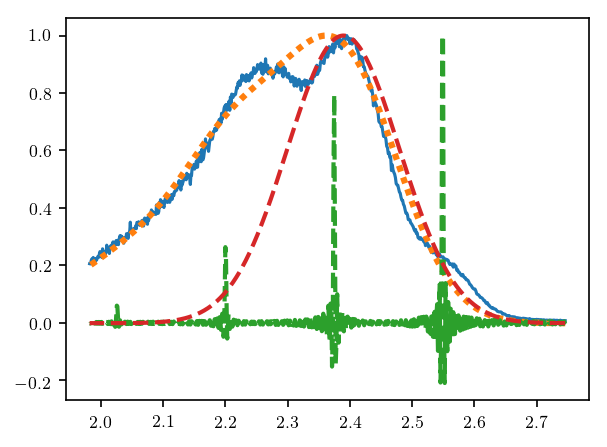

In [69]:
model_fit_inst = model_from_params(model_fit['x'], 2)

model_2_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 1000)

model_1st_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 1000)

model_2nd_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 1000)

plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]))

plt.plot(emily_data.T[0], norm_spec(model_2_mode), ls=(0, (1, 1)), lw=3, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(model_1st_mode), ls='--', lw=2, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(model_2nd_mode), ls='--', lw=2, label='2nd model component')

In [70]:
# hbar_omega_eg_0=2.55,
#     script_d=[1.9, .6],
#     hbar_omega_0=[0.15, .1],
#     hbar_gamma=[.01, .01],
#     T=300

ini_hbar_omega_eg_0 = 2.55
ini_script_d = [1.9, .6]
ini_hbar_omega_0 = [0.15, .1]
ini_hbar_gamma = [.1, .01]
ini_T = 300

bounds_hbar_omega_eg_0 = [2.549, 2.551]
bounds_script_d = [[0, 0], [np.inf, np.inf]]
bounds_hbar_omega_0 = [[.12, 0], [np.inf, np.inf]]
bounds_hbar_gamma = [[0.001, 0], [np.inf, np.inf]]
bounds_T = [299, 301]


fit_ini_guess = np.asarray([
    ini_hbar_omega_eg_0,
    ini_T,
    *ini_hbar_omega_0,
    *ini_hbar_gamma,
    *ini_script_d,
    ])


hbar_omegas_arg = emily_data.T[0]
data_arg = emily_data.T[1]
num_modes_arg = 2
t_bound_arg = 1000
t_points_arg = 1000
norm_arg = True

fit_args = (
    hbar_omegas_arg,
    data_arg,
    num_modes_arg,
    t_bound_arg,
    t_points_arg,
    norm_arg,
    )

## Build bounds arrays
bounds = np.zeros((2, fit_ini_guess.shape[0]))
bounds[:, 0] = bounds_hbar_omega_eg_0
bounds[:, 1] = bounds_T
bounds[:, 2:2+num_modes_arg] = bounds_hbar_omega_0
bounds[:, 2+num_modes_arg:2+2*num_modes_arg] = bounds_hbar_gamma
bounds[:, 2+2*num_modes_arg:2+3*num_modes_arg] = bounds_script_d

model_fit = opt.least_squares(
    muk_mol_fit_fun,
    x0=fit_ini_guess,
    args=fit_args,
    bounds=bounds
    )

In [71]:
model_fit['x']

array([2.54900000e+00, 2.99000515e+02, 1.74304755e-01, 1.20116439e-02,
       1.00000000e-03, 4.53303249e+00, 1.15974610e+00, 5.14557005e+00])

In [72]:
fit_ini_guess

array([2.55e+00, 3.00e+02, 1.50e-01, 1.00e-01, 1.00e-01, 1.00e-02,
       1.90e+00, 6.00e-01])

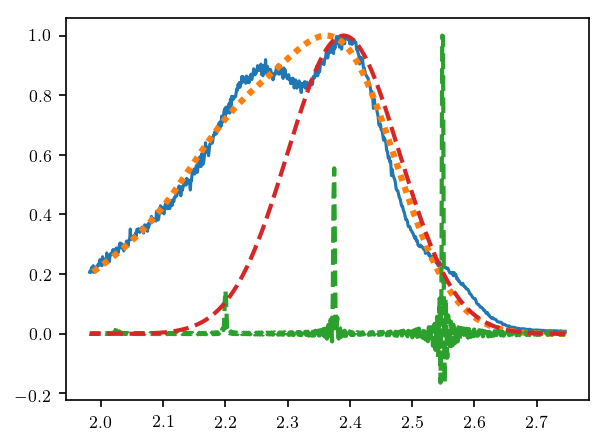

In [73]:
model_fit_inst = model_from_params(model_fit['x'], 2)

model_2_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 1000)

model_1st_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 1000)

model_2nd_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 1000)

plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]))

plt.plot(emily_data.T[0], norm_spec(model_2_mode), ls=(0, (1, 1)), lw=3, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(model_1st_mode), ls='--', lw=2, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(model_2nd_mode), ls='--', lw=2, label='2nd model component')

Try two close in energy 

Text(0.5, 0, 'Photon Energy $\\hbar\\omega$ [eV]')

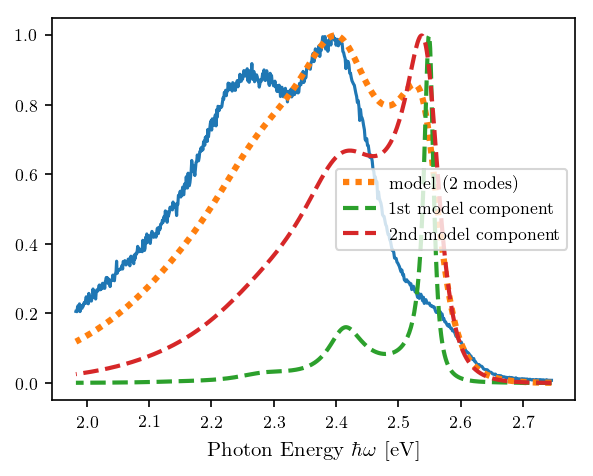

In [91]:
emily_model = dom.mol_fluo_model(
    num_vib_modes=2,
    hbar_omega_eg_0=2.55,
    script_d=[1., 1.4],
    hbar_omega_0=[0.14, .15],
    hbar_gamma=[.05, .1],
    T=300,)

model_2_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 10000)

model_1st_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 10000)

model_2nd_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 10000)

plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]))

plt.plot(emily_data.T[0], norm_spec(model_2_mode), ls=(0, (1, 1)), lw=3, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(model_1st_mode), ls='--', lw=2, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(model_2nd_mode), ls='--', lw=2, label='2nd model component')


plt.legend()
# plt.xlim([1.75, 3])
plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)

In [104]:
# hbar_omega_eg_0=2.55,
#     script_d=[1.9, .6],
#     hbar_omega_0=[0.15, .1],
#     hbar_gamma=[.01, .01],
#     T=300

ini_hbar_omega_eg_0 = 2.55
ini_script_d = [1.9, .6, .2]
ini_hbar_omega_0 = [0.15, .1, .1]
ini_hbar_gamma = [.1, .01, .01]
ini_T = 300

bounds_hbar_omega_eg_0 = [2.549, 2.551]
bounds_script_d = [[0, 0, 0], [np.inf, np.inf, np.inf]]
bounds_hbar_omega_0 = [[.12, 0, 0], [np.inf, np.inf, np.inf]]
bounds_hbar_gamma = [[0.001, 0, 0], [np.inf, np.inf, np.inf]]
bounds_T = [299, 301]


fit_ini_guess = np.asarray([
    ini_hbar_omega_eg_0,
    ini_T,
    *ini_hbar_omega_0,
    *ini_hbar_gamma,
    *ini_script_d,
    ])


hbar_omegas_arg = emily_data.T[0]
data_arg = emily_data.T[1]
num_modes_arg = 3
t_bound_arg = 1000
t_points_arg = 1000
norm_arg = True

fit_args = (
    hbar_omegas_arg,
    data_arg,
    num_modes_arg,
    t_bound_arg,
    t_points_arg,
    norm_arg,
    )

## Build bounds arrays
bounds = np.zeros((2, fit_ini_guess.shape[0]))
bounds[:, 0] = bounds_hbar_omega_eg_0
bounds[:, 1] = bounds_T
bounds[:, 2:2+num_modes_arg] = bounds_hbar_omega_0
bounds[:, 2+num_modes_arg:2+2*num_modes_arg] = bounds_hbar_gamma
bounds[:, 2+2*num_modes_arg:2+3*num_modes_arg] = bounds_script_d

model_fit = opt.least_squares(
    muk_mol_fit_fun,
    x0=fit_ini_guess,
    args=fit_args,
    bounds=bounds
    )

In [108]:
model_fit['x']

array([2.54900000e+00, 2.99034908e+02, 1.74370595e-01, 1.59588697e-02,
       1.99192118e-02, 1.00000000e-03, 1.72392652e+00, 2.30337123e+00,
       1.15030271e+00, 4.01391057e+00, 1.78278178e+00])

In [109]:
fit_ini_guess

array([2.55e+00, 3.00e+02, 1.50e-01, 1.00e-01, 1.00e-01, 1.00e-01,
       1.00e-02, 1.00e-02, 1.90e+00, 6.00e-01, 2.00e-01])

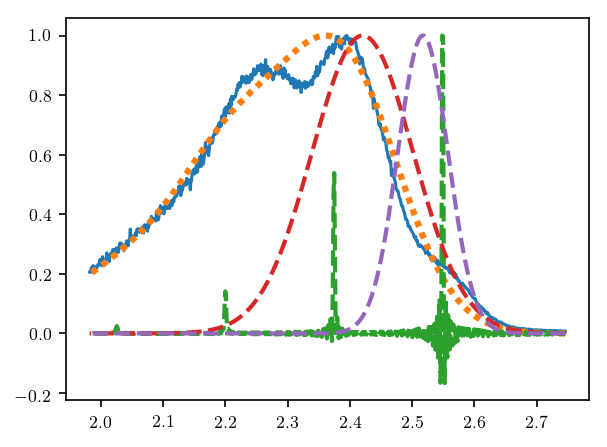

In [110]:
model_fit_inst = model_from_params(model_fit['x'], 3)

model_2_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 1000)

model_1st_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 1000)

model_2nd_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 1000)

model_3rd_mode = model_fit_inst.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=2,
    t_bound = 1000,
    t_points = 1000)

plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]))

plt.plot(emily_data.T[0], norm_spec(model_2_mode), ls=(0, (1, 1)), lw=3, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(model_1st_mode), ls='--', lw=2, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(model_2nd_mode), ls='--', lw=2, label='2nd model component')
plt.plot(emily_data.T[0], norm_spec(model_3rd_mode), ls='--', lw=2, label='3rd model component')

2.54900000e+00, 2.99034908e+02, 1.74370595e-01, 1.59588697e-02,
       1.99192118e-02, 1.00000000e-03, 1.72392652e+00, 2.30337123e+00,
       1.15030271e+00, 4.01391057e+00, 1.78278178e+00])

Text(0.5, 0, 'Photon Energy $\\hbar\\omega$ [eV]')

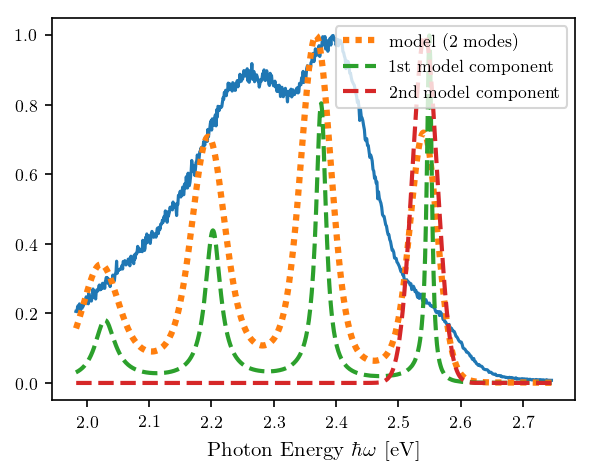

In [118]:
emily_model = dom.mol_fluo_model(
    num_vib_modes=3,
    hbar_omega_eg_0=2.55,
    script_d=[1.8, 1.01391057e+00, .078278178e+00],
    hbar_omega_0=[0.174, .015, .019],
    hbar_gamma=[1.00000000e-02, 1.72392652e+00, 2.30337123e+00,],
    T=300,)

model_3_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 10000)

model_1st_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 10000)

model_2nd_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 10000)

model_3rd_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=2,
    t_bound = 1000,
    t_points = 10000)

plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]))

plt.plot(emily_data.T[0], norm_spec(model_3_mode), ls=(0, (1, 1)), lw=3, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(model_1st_mode), ls='--', lw=2, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(model_2nd_mode), ls='--', lw=2, label='2nd model component')
# plt.plot(emily_data.T[0], norm_spec(model_3rd_mode), ls='--', lw=2, label='2nd model component')


plt.legend()
# plt.xlim([1.75, 3])
plt.xlabel('Photon Energy $\hbar\omega$ [eV]', fontsize=10)

2.63765796e+00, 3.00517498e+02, 1.30774831e-01, 1.09047951e-02,
       5.00000000e-03, 7.76283956e-01, 1.58083799e+00, 2.56037005e+00

Text(0, 0.5, 'Normalized Emission Probability')

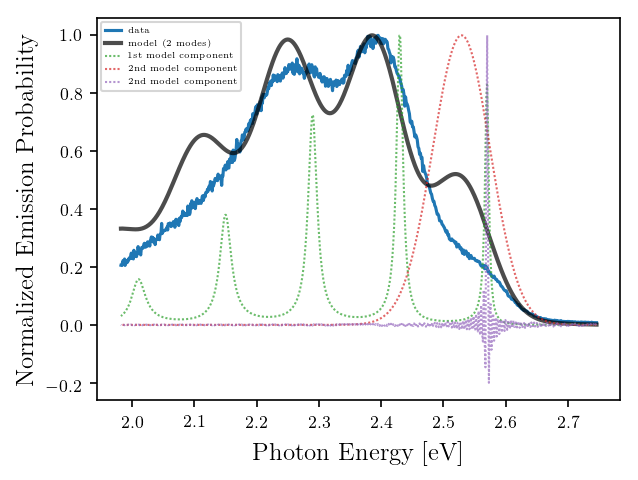

In [140]:
emily_model = dom.mol_fluo_model(
    num_vib_modes=3,
    hbar_omega_eg_0=2.57,
    script_d=[2., 2.760, .078278178e+00],
    hbar_omega_0=[0.14, .0109, .019],
    hbar_gamma=[.005, .09, .01,],
    T=300,)

model_3_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 10000)

model_1st_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 10000)

model_2nd_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 10000)

model_3rd_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=2,
    t_bound = 1000,
    t_points = 10000)

plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]), label='data')

plt.plot(emily_data.T[0], norm_spec(model_3_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(model_1st_mode), ls=(0, (1, 1)), lw=1, c='C2', alpha=0.7, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(model_2nd_mode), ls=(0, (1, 1)), lw=1, c='C3', alpha=0.7, label='2nd model component')
plt.plot(emily_data.T[0], norm_spec(model_3rd_mode), ls=(0, (1, 1)), lw=1, c='C4', alpha=0.7, label='2nd model component')


plt.legend(fontsize=4)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Normalized Emission Probability')

Text(0, 0.5, 'Normalized Emission Probability')

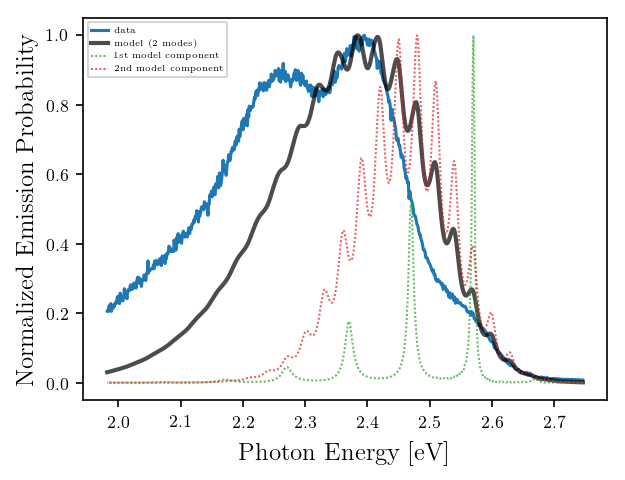

In [163]:
emily_model = dom.mol_fluo_model(
    num_vib_modes=3,
    hbar_omega_eg_0=2.57,
    script_d=[1.4, 2.760, .078278178e+00],
    hbar_omega_0=[0.1, .03, .019],
    hbar_gamma=[.005, .001, .01,],
    T=300,)

model_3_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 10000)

model_1st_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 10000)

model_2nd_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 10000)

model_3rd_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=2,
    t_bound = 1000,
    t_points = 10000)

plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]), label='data')

plt.plot(emily_data.T[0], norm_spec(model_3_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(model_1st_mode), ls=(0, (1, 1)), lw=1, c='C2', alpha=0.7, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(model_2nd_mode), ls=(0, (1, 1)), lw=1, c='C3', alpha=0.7, label='2nd model component')
# plt.plot(emily_data.T[0], norm_spec(model_3rd_mode), ls=(0, (1, 1)), lw=1, c='C4', alpha=0.7, label='2nd model component')


plt.legend(fontsize=4)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Normalized Emission Probability')

Text(0, 0.5, 'Normalized Emission Probability')

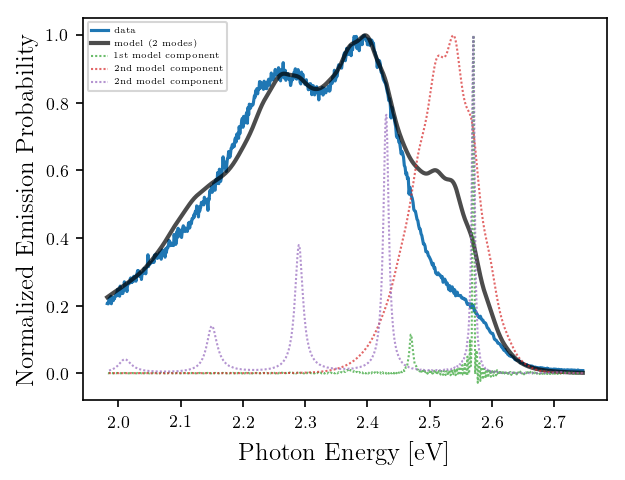

In [178]:
emily_model = dom.mol_fluo_model(
    num_vib_modes=3,
    hbar_omega_eg_0=2.57,
    script_d=[0.8, 1.8, 1.7],
    hbar_omega_0=[0.1, .03, 0.14],
    hbar_gamma=[.005, .005, .005],
    T=300,)

model_3_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 10000)

model_1st_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 10000)

model_2nd_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 10000)

model_3rd_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=2,
    t_bound = 1000,
    t_points = 10000)

plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]), label='data')

plt.plot(emily_data.T[0], norm_spec(model_3_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(model_1st_mode), ls=(0, (1, 1)), lw=1, c='C2', alpha=0.7, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(model_2nd_mode), ls=(0, (1, 1)), lw=1, c='C3', alpha=0.7, label='2nd model component')
plt.plot(emily_data.T[0], norm_spec(model_3rd_mode), ls=(0, (1, 1)), lw=1, c='C4', alpha=0.7, label='2nd model component')


plt.legend(fontsize=4)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Normalized Emission Probability')

Text(0, 0.5, 'Normalized Emission Probability')

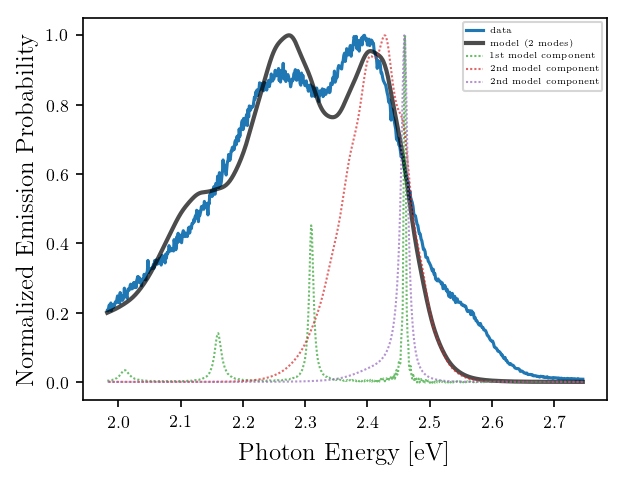

In [217]:
emily_model = dom.mol_fluo_model(
    num_vib_modes=3,
    hbar_omega_eg_0=2.46,
    script_d=[1.4, 1.8, .5],
    hbar_omega_0=[0.15, .03, 0.08],
    hbar_gamma=[.005, .005, .08],
    T=300,)

model_3_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 10000)

model_1st_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 10000)

model_2nd_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 10000)

model_3rd_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=2,
    t_bound = 1000,
    t_points = 10000)

plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]), label='data')

plt.plot(emily_data.T[0], norm_spec(model_3_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(model_1st_mode), ls=(0, (1, 1)), lw=1, c='C2', alpha=0.7, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(model_2nd_mode), ls=(0, (1, 1)), lw=1, c='C3', alpha=0.7, label='2nd model component')
plt.plot(emily_data.T[0], norm_spec(model_3rd_mode), ls=(0, (1, 1)), lw=1, c='C4', alpha=0.7, label='2nd model component')


plt.legend(fontsize=4)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Normalized Emission Probability')

In [193]:
dom.invcmtohz(250)*hbar

0.030996049346900714

In [196]:
kb*300

0.0258519909

Text(0, 0.5, 'Normalized Emission Probability')

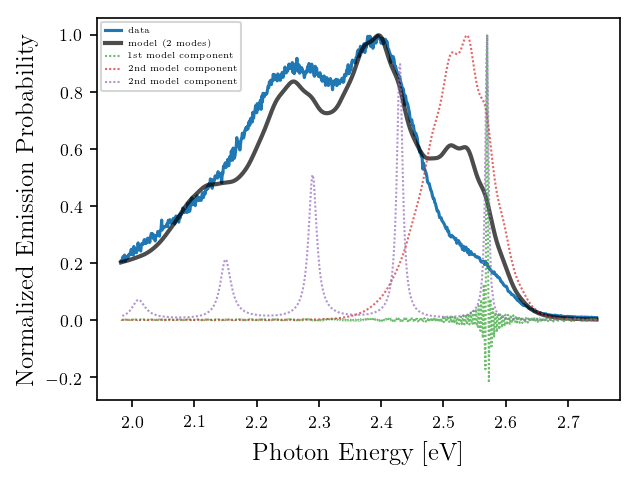

In [188]:
emily_model = dom.mol_fluo_model(
    num_vib_modes=3,
    hbar_omega_eg_0=2.57,
    script_d=[0., 1.8, 1.8],
    hbar_omega_0=[0.1, .03, 0.14],
    hbar_gamma=[.005, .005, .005],
    T=300,)

model_3_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 10000)

model_1st_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 10000)

model_2nd_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 10000)

model_3rd_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=2,
    t_bound = 1000,
    t_points = 10000)

plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]), label='data')

plt.plot(emily_data.T[0], norm_spec(model_3_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(model_1st_mode), ls=(0, (1, 1)), lw=1, c='C2', alpha=0.7, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(model_2nd_mode), ls=(0, (1, 1)), lw=1, c='C3', alpha=0.7, label='2nd model component')
plt.plot(emily_data.T[0], norm_spec(model_3rd_mode), ls=(0, (1, 1)), lw=1, c='C4', alpha=0.7, label='2nd model component')


plt.legend(fontsize=4)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Normalized Emission Probability')

Text(0, 0.5, 'Normalized Emission Probability')

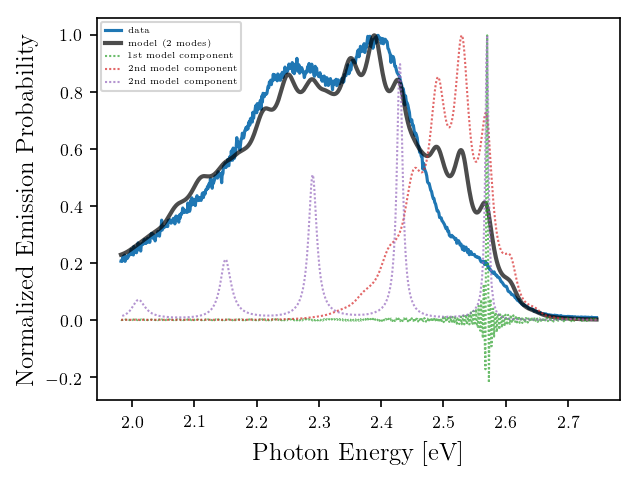

In [186]:
emily_model = dom.mol_fluo_model(
    num_vib_modes=3,
    hbar_omega_eg_0=2.57,
    script_d=[0.0, 1.8, 1.8],
    hbar_omega_0=[0.1, .04, 0.14],
    hbar_gamma=[.005, .005, .005],
    T=300,)

model_3_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 10000)

model_1st_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 10000)

model_2nd_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 10000)

model_3rd_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=2,
    t_bound = 1000,
    t_points = 10000)

plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]), label='data')

plt.plot(emily_data.T[0], norm_spec(model_3_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(model_1st_mode), ls=(0, (1, 1)), lw=1, c='C2', alpha=0.7, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(model_2nd_mode), ls=(0, (1, 1)), lw=1, c='C3', alpha=0.7, label='2nd model component')
plt.plot(emily_data.T[0], norm_spec(model_3rd_mode), ls=(0, (1, 1)), lw=1, c='C4', alpha=0.7, label='2nd model component')


plt.legend(fontsize=4)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Normalized Emission Probability')

Text(0, 0.5, 'Normalized Emission Probability')

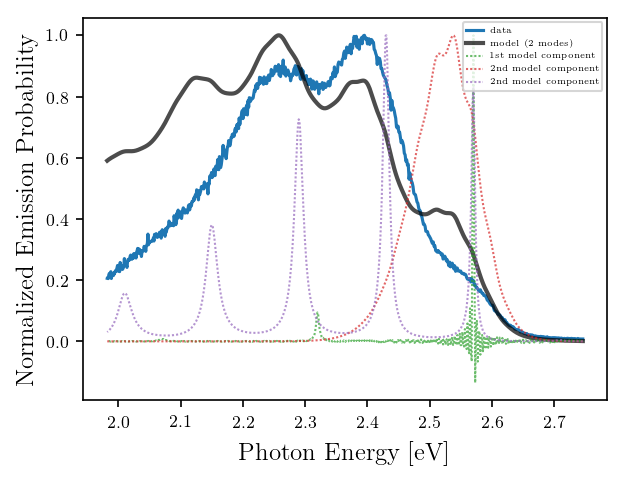

In [183]:
emily_model = dom.mol_fluo_model(
    num_vib_modes=3,
    hbar_omega_eg_0=2.57,
    script_d=[0.8, 1.8, 2],
    hbar_omega_0=[0.25, .03, 0.14],
    hbar_gamma=[.005, .005, .005],
    T=300,)

model_3_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 10000)

model_1st_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 10000)

model_2nd_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 10000)

model_3rd_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=2,
    t_bound = 1000,
    t_points = 10000)

plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]), label='data')

plt.plot(emily_data.T[0], norm_spec(model_3_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(model_1st_mode), ls=(0, (1, 1)), lw=1, c='C2', alpha=0.7, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(model_2nd_mode), ls=(0, (1, 1)), lw=1, c='C3', alpha=0.7, label='2nd model component')
plt.plot(emily_data.T[0], norm_spec(model_3rd_mode), ls=(0, (1, 1)), lw=1, c='C4', alpha=0.7, label='2nd model component')


plt.legend(fontsize=4)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Normalized Emission Probability')

04/27

Text(0, 0.5, 'Normalized Emission Probability')

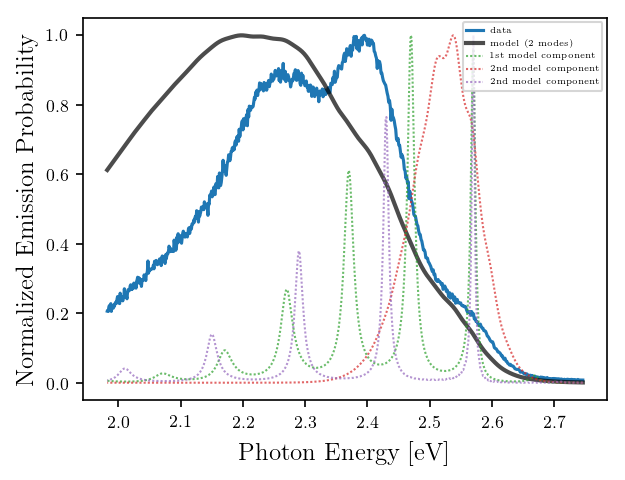

In [218]:
emily_model = dom.mol_fluo_model(
    num_vib_modes=3,
    hbar_omega_eg_0=2.57,
    script_d=[1.8, 1.8, 1.7],
    hbar_omega_0=[0.1, .03, 0.14],
    hbar_gamma=[.005, .005, .005],
    T=300,)

model_3_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
#     mode_idx,
    t_bound = 1000,
    t_points = 10000)

model_1st_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=0,
    t_bound = 1000,
    t_points = 10000)

model_2nd_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=1,
    t_bound = 1000,
    t_points = 10000)

model_3rd_mode = emily_model.emission_lineshape(
    emily_data.T[0]/hbar,
    mode_idx=2,
    t_bound = 1000,
    t_points = 10000)

plt.plot(emily_data.T[0], norm_spec(emily_data.T[1]), label='data')

plt.plot(emily_data.T[0], norm_spec(model_3_mode), ls='-', lw=2, c='k', alpha=0.7, label='model (2 modes)')
plt.plot(emily_data.T[0], norm_spec(model_1st_mode), ls=(0, (1, 1)), lw=1, c='C2', alpha=0.7, label='1st model component')
plt.plot(emily_data.T[0], norm_spec(model_2nd_mode), ls=(0, (1, 1)), lw=1, c='C3', alpha=0.7, label='2nd model component')
plt.plot(emily_data.T[0], norm_spec(model_3rd_mode), ls=(0, (1, 1)), lw=1, c='C4', alpha=0.7, label='2nd model component')


plt.legend(fontsize=4)
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Normalized Emission Probability')